# Day 25- Beginner Data Science Project

## Predict Housing Prices using a selection of features in the [Centadata set](http://centadata.publicdata.hk)

### The Data Science Process:
1. Perform Exploratory data analysis
2. Cleanup and replace missing values or drop columns as required.
3. Predict the target variable.
4. Evaluate the accuracy of the model
5. Perform Cross validation of your model and tabulate results.
6. Can you improve the model performance? if yes, how? 
7. Apply more than one possible algorithm on the data to compare and evaluate performance?
8. Recommend the best algorithm given the dataset and its features.
9. Prepare a presentation for each of your findings and recommendation.

## I. Getting Data, Data Wrangling, and Exploratory Data Analysis

## Preliminary

In [1]:
import requests, json # for getting data
from urllib.parse import urlencode

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#### let's get data

In [20]:
base_url = 'https://centadata.publicdata.hk/centadata-54990be.json'
params = {
    "sql": "select * from centadataall where txdate > '2017-01-01'"
}
url_params = urlencode( params )
target_url = base_url + "?" + url_params

data = requests.get( base_url, params )

if data.status_code == 200:
    cdata = json.loads( data.text )
    raw = pd.DataFrame(data = cdata['rows'],
                     columns = cdata['columns']
                     )
else:
    print(f"Can't download data with error code:{data.status_code} for {target_url}")

In [21]:
raw.dtypes

unitcode                      object
txdate                        object
price                          int64
buildingcode                  object
saleablearea                 float64
grossarea                    float64
xaxis                         object
yaxis                         object
buildingname                  object
phasecode                     object
phasename                     object
estatecode                    object
estatename                    object
buildingaddress               object
dateofcompletion              object
numberofunits                  int64
numberoffloors                 int64
flatsperfloor                  int64
schoolnet                     object
buildingnamechinese           object
phasenamechinese              object
estatenamechinese             object
buildingaddresschinese        object
region                        object
regionchinese                 object
regioncode                     int64
propertydeveloperchinese      object
p

#### Let's drop some obviously unneccessary columns

... and some not so obvious:
1. _Building Name_, _Phase Name_, _Estate Name_: the name basically describle the same dimension of information as the address and region does
2. _xaxis_: too building specific
* _property developer_ & _property manager_: this probably has some impact on the value but encoding this could be a challenge

and **building address**, is a higher dimenion of the `schoolnet` and `region` data that is potentially very important. **A useful thing to do is actually to run an unsupervised ML model on the address with prices to discover different pockets in Hong Kong.** This can be visually represented further on a map. The _pockets_ or clusters can be passed further back into the regression model as a feature to help improve the model's predictability.

In [22]:
l_col_to_drop = [
    'unitcode', 'buildingcode', 'buildingname',
    #'xaxis', <- need this for duplicate checking
    #'buildingaddress',
    'phasecode', 'phasename',
    'estatecode', 'estatename',
    'buildingnamechinese', 'phasenamechinese', 'estatenamechinese', 'buildingaddresschinese', 'regionchinese',
    'regioncode',
    'propertydeveloperchinese','propertyfacilitieschinese','propertymanagerchinese'
]
df = raw.drop( columns = l_col_to_drop )

#### Let's write this to a CSV to reduce download time

In [27]:
fname = 'data/centadata_df.csv'
uinput = input('Write [w], or Load [l]:').upper()

if uinput == 'L':
    df = pd.read_csv(fname, index_col = 0)
    print( f'data file {fname} loaded into dataframe: df')
elif uinput == 'W':
    df.to_csv(fname)
    print(f'data written to {fname}')
else:
    print(f'Invalid input: {uinput}; Nothing done.')
    

Write [w], or Load [l]:w
data written to data/centadata_df.csv


In [28]:
df.head()

,txdate,price,saleablearea,grossarea,xaxis,yaxis,buildingaddress,dateofcompletion,numberofunits,numberoffloors,flatsperfloor,schoolnet,region
0,2017-02-16,2880000,392.0,NaN,NO. 205A,2/F,205A TUNG CHOI STREET,1963-08-01,8,8,1,九龍區32號校網,Mongkok/Yaumatei
1,2018-01-11,3000000,392.0,NaN,NO. 205A,3/F,205A TUNG CHOI STREET,1963-08-01,8,8,1,九龍區32號校網,Mongkok/Yaumatei
2,2017-06-26,51000000,1912.0,2500.0,NO. 4B,5/F,4A-4B WONG NAI CHUNG GAP ROAD,1965-09-01,8,8,1,香港區12號校網,Happy Valley/Mid Level East
3,2018-03-21,4150000,294.0,487.0,FLAT B,16/F,98 TSEUK LUK STREET,1999-01-01,30,15,2,九龍區43號校網,Diamond Hill/Wong Tai Sin
4,2017-11-28,5250000,530.0,NaN,FLAT B,8/F,54-58 SOUTH WALL ROAD,1969-10-01,32,9,4,九龍區41號校網,Diamond Hill/Wong Tai Sin


### Missing Data

Text(176,0.5,'missing data')

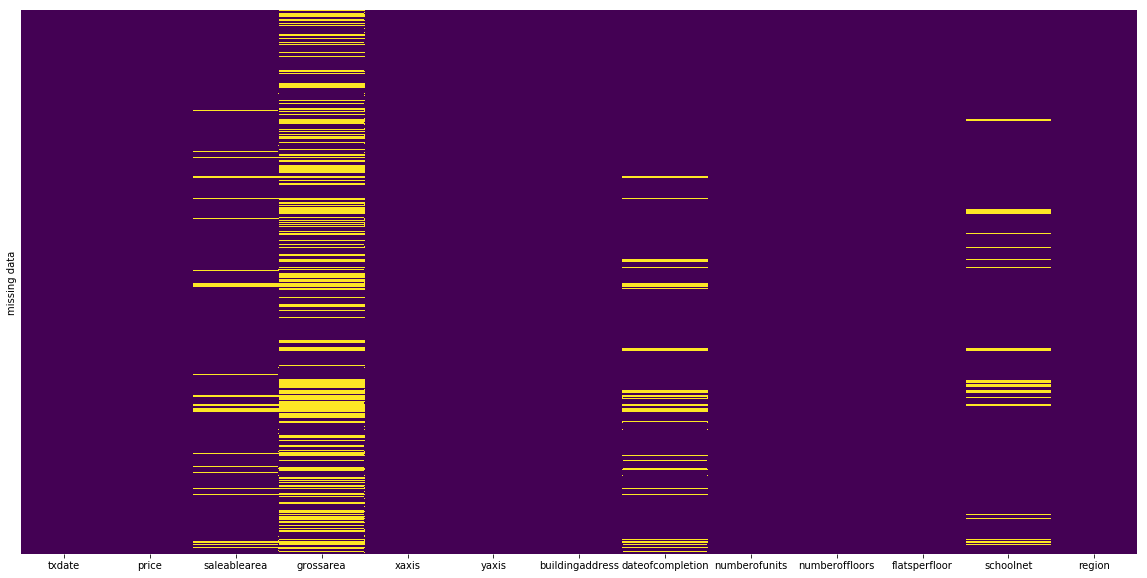

In [29]:
plt.figure(figsize = (20,10))
sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')
plt.ylabel('missing data')

#### Drop Missing
we expect that `grossarea` has a very similar effect as `saleablearea`, and because so many transaction is missing it; it might be smart to drop it.

In [30]:
df_new = df.drop( columns = 'grossarea').dropna()
print( f'original df shape: {df.shape}')
print( f'without missing data: {df_new.shape}')

original df shape: (101938, 13)
without missing data: (88422, 12)


In [34]:
bol_hasmissing = all(df_new.isna() == False)
print( f'No more missing data: {bol_hasmissing}')

No more missing data: True


### Duplicate Data

In [36]:
l_dup_check = ['txdate','price', 'saleablearea', 'yaxis', 'buildingaddress', 'dateofcompletion']
df_dup = df_new[df_new.duplicated( subset = l_dup_check, keep = False)]
print( f' Found { len ( df_dup )} duplicated records.')

df_dup.head(10)

 Found 238 duplicated records.


,txdate,price,saleablearea,xaxis,yaxis,buildingaddress,dateofcompletion,numberofunits,numberoffloors,flatsperfloor,schoolnet,region
805,2017-07-31,4400000,293.0,FLAT B,4/F,248 HOLLYWOOD ROAD,1995-11-01,8,4,2,香港區11號校網,Sheung Wan/Central/Admiralty
806,2017-07-31,4400000,293.0,FLAT A,4/F,248 HOLLYWOOD ROAD,1995-11-01,8,4,2,香港區11號校網,Sheung Wan/Central/Admiralty
1066,2017-10-23,5680000,382.0,NO. 382,2/F,380-382 QUEEN'S ROAD WEST,1974-06-01,10,5,2,香港區11號校網,Kennedy Town/Sai Yin Pun
1068,2017-10-23,5680000,382.0,NO. 380,2/F,380-382 QUEEN'S ROAD WEST,1974-06-01,10,5,2,香港區11號校網,Kennedy Town/Sai Yin Pun
2853,2018-01-15,33390000,1421.0,NO. 86D,1/F,86A-86D POK FU LAM ROAD,1960-06-01,16,4,4,香港區11號校網,Mid Level West
2855,2018-01-15,33390000,1421.0,NO. 86D,3/F,86A-86D POK FU LAM ROAD,1960-06-01,16,4,4,香港區11號校網,Mid Level West
2857,2018-01-15,33390000,1421.0,NO. 86C,1/F,86A-86D POK FU LAM ROAD,1960-06-01,16,4,4,香港區11號校網,Mid Level West
2859,2018-01-15,33390000,1421.0,NO. 86C,3/F,86A-86D POK FU LAM ROAD,1960-06-01,16,4,4,香港區11號校網,Mid Level West
2860,2018-01-15,42140000,1894.0,NO. 86B,G/F,86A-86D POK FU LAM ROAD,1960-06-01,16,4,4,香港區11號校網,Mid Level West
2862,2018-01-15,42140000,1894.0,NO. 86B,2/F,86A-86D POK FU LAM ROAD,1960-06-01,16,4,4,香港區11號校網,Mid Level West


In [38]:
df_clean = df_new.drop_duplicates(subset = l_dup_check, keep = 'first')
print( f'Dropped {len(df_new) - len(df_clean)} duplicated records.')

Dropped 124 duplicated records.


### Data Cleaning & Feature Engineering
* `price`: transform into price per square foot, `price_per_sqf` for ease of comparison
* `dateofcompletion`: into `building_age`
* `txdate`: into `deal_age`, `deal_year`
* `yaxis`: into `floor_number` and `is_dettached`
* `schoolnet`: translate from Chinese into `schoolnet_en`

Create a `price_per_sqf` column

In [47]:
df_clean['price_per_sqf'] = df_clean['price']/ df_clean['saleablearea']

/Users/JHO/.virtualenvs/accelerateHK3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Get `building_age`

In [78]:
from datetime import datetime
today = datetime.today()

df_clean['dateofcompletion'] = df_clean['dateofcompletion'].astype('datetime64[ns]')
df_clean['txdate'] = df_clean['txdate'].astype('datetime64[ns]')

df_clean['building_age'] = df_clean['dateofcompletion'].apply(lambda x: (today - x).days / 365.25)
df_clean['deal_age'] = df_clean['txdate'].apply(lambda x: (today - x).days)
df_clean['deal_year'] = df_clean['txdate'].apply(lambda x: x.year)

/Users/JHO/.virtualenvs/accelerateHK3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/JHO/.virtualenvs/accelerateHK3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/JHO/.virtualenvs/accelerateHK3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

define dettach homes first; `flat_type` = `d` for detached  
`None` is set for normal flats; [this](http://www.residentmar.io/2016/06/12/null-and-missing-data-python.html) talks about the natural of **non-data**

In [98]:
def get_flattype( row ):
    ft = None
    if ( row.numberofunits == 1 or 
        'house' in row.yaxis.lower()
       ):
        ft = 'd'   # detached
    elif 'no.' in row.yaxis.lower() :
        ft = 'l'   # luxury
    elif row.yaxis == 'P/H':
        ft = 'p'   # penthouse
    
    return ft

df_clean['flat_type'] = df_clean.apply( lambda x: get_flattype(x) , axis =1 )

/Users/JHO/.virtualenvs/accelerateHK3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [147]:
import re

def get_floor_num(x):
    m = re.search(r'(\d+|G{1})/F', x)
    num = np.nan  # set to 0 by default; lots of whole buildings
    if m is None:
        pass
#         if x == 'L/G':
#             num = -1
#         elif x == 'U/G':
#             num = -2
    else:
        num = m.group(1)
        if num == 'G':
            num = 0
        int(num)
    return num

df_clean['floor_number'] = df_clean.apply( 
                            lambda x : get_floor_num( x.yaxis) if x.flat_type == None else 0,
                            axis = 1
                            )
df_clean[ 'floor_number'] = df_clean.apply( 
                            lambda x: x.numberoffloors if x.flat_type == 'p' else x.floor_number ,
                            axis = 1)

df_clean['flat_type'] = df_clean.apply(
                            lambda x: 'b' if np.isnan( float(x.floor_number)) else x.flat_type ,
                            axis = 1
                        )

df_clean['floor_number'] = df_clean.floor_number.astype('int64')

# df_new['floor_number'] = df_new['yaxis'].apply( get_floor_num )
# df_new['is_dettached'] = df_new['floor_number'].apply( lambda x: 1 if pd.isnull(x) else 0)
# df_new['floor_number'] = df_new['floor_number'].fillna(0)

/Users/JHO/.virtualenvs/accelerateHK3/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/JHO/.virtualenvs/accelerateHK3/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/JHO/.virtualenvs/accelerateHK3/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

let's make normal `flat_type` = `n` 

In [177]:
df_clean['flat_type'] = df_clean.flat_type.apply(
                        lambda x: 'n' if x is None else x )

/Users/JHO/.virtualenvs/accelerateHK3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


There's also a duplicate region `Hung Hom` and `Hung Hum`

In [159]:
df_clean['region'] = df_clean.region.apply(
                        lambda x: 'Hung Hom' if x == 'Hung Hum' else x
                        )
sorted( df_clean.region.unique())

/Users/JHO/.virtualenvs/accelerateHK3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


['Aberdeen/Ap Lei Chau',
 'Belvedere Garden/Castle Peak Road (Tsuen Wan Porti',
 'Cheung Sha Wan West',
 'Cheung Sha Wan/Sham Shui Po',
 'Cyber-Port',
 'Diamond Hill/Wong Tai Sin',
 'Discovery Bay',
 'Fairview Park/Palm Spring/The Vineyard',
 'Fotan/Shatin Mid Level/Kau To Shan',
 'Happy Valley/Mid Level East',
 'Heng Fa Chuen',
 "Ho Man Tin/King's Park",
 'Hung Hom',
 'Kai Tak',
 'Kennedy Town/Sai Yin Pun',
 'Kowloon Bay/Ngau Chi Wan',
 'Kowloon Station',
 'Kowloon Tong/Beacon Hill',
 'Kwai Chung',
 'Kwun Tong',
 'Lam Tin/Yau Tong',
 'Ma On Shan',
 'Ma Wan/Park Island',
 'Mei Foo/Wonderland',
 'Mid Level Central',
 'Mid Level North Point',
 'Mid Level West',
 'Mongkok/Yaumatei',
 'North Point/Fortress Hill',
 'Olympic Station',
 'Peak/South',
 'Quarry Bay/Kornhill',
 'Sai Kung',
 'Sham Tseng/Castle Peak Road (Tuen Mun Portion)',
 'Shatin',
 'Shau Kei Wan/Chai Wan',
 'Sheung Shui/Fanling/Kwu Tung',
 'Sheung Wan/Central/Admiralty',
 'South Horizon',
 'Tai Po Market/Tai Wo',
 'Tai Po Mid

translating `schoolnet` using [Yandex Translate API](https://tech.yandex.com/translate/doc/dg/reference/translate-docpage/)

In [162]:
y_api_key = 'trnsl.1.1.20181114T024427Z.ff404c0045841b1a.7149dd078b7c5251bff61e0e0cc194a6ea5aade4'
base_url = 'https://translate.yandex.net/api/v1.5/tr.json/translate'

l_schoolnet = list( df_new['schoolnet'].unique())
params = {
    'key': y_api_key,
    'lang': 'zh-en',
    'text': l_schoolnet
}
url_params = urlencode( params )
target_url = base_url + "?" + url_params

data = requests.get( base_url, params )

if data.status_code == 200:
    data_json = json.loads( data.text )
    l_schoolnet_en = list(data_json['text'])
    
    schoolnet_dict = {
        zh : en for zh, en in zip( l_schoolnet, l_schoolnet_en)
    }
    
    df_clean['schoolnet_en'] = df_clean['schoolnet'].apply( lambda x: schoolnet_dict[x])
    print(f'Translated {len(l_schoolnet_en)} school net names and created new column "schoolnet_en"')
else:
    print(f"Can't download data with error code:{data.status_code} for {target_url}")

Translated 35 school net names and created new column "schoolnet_en"


/Users/JHO/.virtualenvs/accelerateHK3/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [166]:
l_int = [
        'numberofunits', 'numberoffloors', 'flatsperfloor', 'floor_number', 
        'deal_age', 'deal_year'
]

df_clean[ l_int ] = df_clean[ l_int ].astype('int64')

/Users/JHO/.virtualenvs/accelerateHK3/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [178]:
df_clean.sample(10)

,txdate,price,saleablearea,xaxis,yaxis,buildingaddress,dateofcompletion,numberofunits,numberoffloors,flatsperfloor,schoolnet,region,price_per_sqf,flat_type,floor_number,building_age,deal_age,deal_year,schoolnet_en
64207,2017-07-28,16144900,936.0,FLAT C,17/F,8 FO CHUN ROAD,2012-12-01,71,15,5,新界區84號校網,Tai Po Mid Level/Hong Lok Yuen,17248.824786,n,17,5.965777,479,2017,The new territories District Number 84 school ...
63015,2017-11-21,8000000,668.0,FLAT B,10/F,8 PAK LAI ROAD,2002-08-01,148,19,8,新界區62號校網,Ma Wan/Park Island,11976.047904,n,10,16.301164,363,2017,New Territories No. 62 school network
81768,2018-05-29,5500000,304.0,FLAT A,1/F,6-8A TUNG FONG STREET,1979-01-01,69,23,3,九龍區31號校網,Mongkok/Yaumatei,18092.105263,n,1,39.882272,174,2018,Kowloon district No. 31 school website
25281,2017-09-19,5250000,382.0,FLAT F,9/F,120 LUNG CHEUNG ROAD,1986-07-01,264,33,8,九龍區43號校網,Diamond Hill/Wong Tai Sin,13743.455497,n,9,32.386037,426,2017,Kowloon district No. 43 school network
9352,2017-04-27,5638000,526.0,FLAT B,25/F,88 PAK WO ROAD,1995-11-01,272,34,8,新界區81號校網,Sheung Shui/Fanling/Kwu Tung,10718.631179,n,25,23.049966,571,2017,The new territories District No. 81 school net...
87038,2018-06-28,14800000,712.0,FLAT A,26/F,103 ROBINSON ROAD,1989-06-01,140,24,6,香港區11號校網,Mid Level West,20786.516854,n,26,29.467488,144,2018,Hong Kong District No. 11 school network
17847,2017-02-14,8000000,1022.0,FLAT D,6/F,33 TIN PING ROAD,1996-04-01,72,9,8,新界區80號校網,Sheung Shui/Fanling/Kwu Tung,7827.788650,n,6,22.633812,643,2017,The new territories District No. 80 school net...
83957,2018-06-11,4400000,269.0,FLAT 2,23/F,20-30 TAI CHUNG KIU ROAD,1984-09-01,264,33,8,新界區91號校網,Shatin,16356.877323,n,23,34.214921,161,2018,The new territories District No. 91 school net...
67629,2018-01-22,5065000,380.0,FLAT F,16/F,80 TSUEN KING CIRCUIT,1988-06-01,264,33,8,新界區62號校網,Tsuen Wan,13328.947368,n,16,30.466804,301,2018,New Territories No. 62 school network
9116,2017-03-01,5345200,247.0,FLAT A,25/F,200 MA TAU WAI ROAD,2017-12-01,120,24,5,九龍區35號校網,To Kwa Wan,21640.485830,n,25,0.966461,628,2017,Kowloon district No. 35 school network


In [179]:
df_clean.dtypes

txdate              datetime64[ns]
price                        int64
saleablearea               float64
xaxis                       object
yaxis                       object
buildingaddress             object
dateofcompletion    datetime64[ns]
numberofunits                int64
numberoffloors               int64
flatsperfloor                int64
schoolnet                   object
region                      object
price_per_sqf              float64
flat_type                   object
floor_number                 int64
building_age               float64
deal_age                     int64
deal_year                    int64
schoolnet_en                object
dtype: object

#### Let's save the cleaned data for use later

In [180]:
fname = 'data/centadata_clean.csv'
df_clean.to_csv(fname)

## Findings
* `price` even when normalized into `norm_price` is **not** normally distributed.
    * it is supectible to `region`. Maybe a model should be built on regional data?
    * maybe we should remove outlines that are over 10 std dev?
* `schoolnet_en` seems like a valuable feature
* the new feature `is_dettached` proves to be a major cause of outliners

### Useful References:
https://api.portal.hkmapservice.gov.hk/  
http://www1.map.gov.hk/gih3/view/index.jsp  
https://www.28hse.com/utf8/schoolnetwork_c11-P2.html